# predict on one image

In [1]:
import sys
sys.path.append('../')

In [2]:
from main import load_vgg
from main import layers

TensorFlow Version: 1.8.0
Tests Passed
Tests Passed


../main.py:15: UserWarning: No GPU found. Please use a GPU to train your neural network.
  warnings.warn('No GPU found. Please use a GPU to train your neural network.')


Tests Passed
INFO:tensorflow:Restoring parameters from b'../data/vgg/variables/variables'
INFO:tensorflow:Restoring parameters from b'../data/vgg/variables/variables'
INFO:tensorflow:Restoring parameters from b'../data/vgg/variables/variables'
INFO:tensorflow:Restoring parameters from b'../data/vgg/variables/variables'
INFO:tensorflow:Restoring parameters from b'../data/vgg/variables/variables'


## generate only one image

In [3]:
def gen_batch_function(data_folder, image_shape):
    """
    Generate function to create batches of training data
    :param data_folder: Path to folder that contains all the datasets
    :param image_shape: Tuple - Shape of image
    :return:
    """
    def get_batches_fn(batch_size):
        """
        Create batches of training data
        :param batch_size: Batch Size
        :return: Batches of training data
        """
        image_paths = glob(os.path.join(data_folder, 'image_2', '*.png'))
        label_paths = {
            re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
            for path in glob(os.path.join(data_folder, 'gt_image_2', '*_road_*.png'))}
        background_color = np.array([255, 0, 0])

        random.shuffle(image_paths)
        for batch_i in range(1):
            images = []
            gt_images = []
            for image_file in image_paths[batch_i:batch_i+batch_size]:
                gt_image_file = label_paths[os.path.basename(image_file)]

                # scipy imresize deprecated. i can bump down the version of scipy. but eh.
                # let's use opencv
                # image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)
                # gt_image = scipy.misc.imresize(scipy.misc.imread(gt_image_file), image_shape)
                image = cv2.resize(cv2.imread(image_file), image_shape[::-1])
                gt_image = cv2.resize(cv2.imread(gt_image_file), image_shape[::-1])

                gt_bg = np.all(gt_image == background_color, axis=2)
                gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
                gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)

                images.append(image)
                gt_images.append(gt_image)

            yield np.array(images), np.array(gt_images)
    return get_batches_fn

## parameters

In [4]:
import tensorflow as tf
import os
from glob import glob
import re
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

In [5]:
num_classes = 2
image_shape = (160, 576)
data_dir = '../data'
runs_dir = './runs'

input_image = tf.placeholder(tf.float32, shape=[None, *image_shape, 3])
correct_label = tf.placeholder(tf.float32, shape=[None, *image_shape, num_classes])
learning_rate = tf.placeholder(tf.float32, shape=[])

In [6]:
epoch = 1
batch_size = 1

In [42]:
# model

In [43]:
sess = tf.InteractiveSession()
    
# Path to vgg model
vgg_path = os.path.join(data_dir, 'vgg')
# Create function to get batches
get_batches_fn = gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)

#  Build NN using load_vgg, layers, and optimize function
input_image, keep_prob, layer3_out, layer4_out, layer7_out = load_vgg(sess, vgg_path)

output = layers(layer3_out, layer4_out, layer7_out, num_classes)

sess.run(tf.global_variables_initializer())

In [84]:
# predict
image_file = glob(os.path.join('../data/data_road/testing', 'image_2', '*.png'))[0]
image = cv2.resize(cv2.imread(image_file), image_shape[::-1])
im_softmax = sess.run(tf.nn.softmax(output), {keep_prob: 0.1, input_image: image[None,:]})

In [85]:
im_softmax.shape

(1, 160, 576, 2)

In [77]:
im_softmax = im_softmax[0][:,:,1]
segmentation = (im_softmax > 0.5)[:,:,None]
mask = np.dot(segmentation, np.array([[0, 255, 0]], dtype='uint8'))
street_im = cv2.addWeighted(image, 1, mask, 0.5, 0)

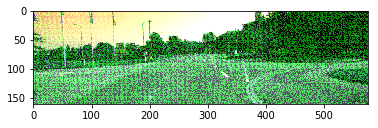

In [78]:
plt.imshow(street_im)

In [79]:
mask.shape

(160, 576, 3)

AttributeError: 'list' object has no attribute 'shape'